In [1]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import tensorflow as tf
from tensorflow.random import set_seed
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPool2D,Flatten,Dense,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator,img_to_array,load_img
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from tqdm import tqdm
# %load_ext tensorboard

In [ ]:
!python --version

Python 3.10.11


In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# !unzip "drive/MyDrive/archive (7).zip"

In [ ]:
tf.__version__

'2.12.0'

In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
DATA_PATH = os.path.join('Vegetable Images')

In [4]:
TRAIN_PATH = os.path.join(DATA_PATH, "train")
VAL_PATH = os.path.join(DATA_PATH, "validation")
TEST_PATH = os.path.join(DATA_PATH, "test")

In [5]:
CLASSES = os.listdir(TRAIN_PATH)
print(CLASSES)

['Cauliflower', 'Potato', 'Bean', 'Tomato', 'Papaya', 'Cabbage', 'Cucumber', 'Bitter_Gourd', 'Radish', 'Carrot', 'Brinjal', 'Broccoli', 'Pumpkin', 'Capsicum', 'Bottle_Gourd']


In [ ]:
rows=2 #rows in subplots
cols=5 #columns in subplots

for class_ in CLASSES:
    fig,ax = plt.subplots(rows,cols,figsize=(12,4))
    r = 0
    c = 0
    img_files_in_class_ = os.listdir(os.path.join(TRAIN_PATH, class_))
    print(f'\n{class_.upper()}')
    for i in range(rows*cols):
        img = plt.imread(os.path.join(TRAIN_PATH, class_, img_files_in_class_[i]))
        ax[r,c].axis("off")
        ax[r,c].imshow(img)
        c+=1
        if c == cols:
            c=0
            r+=1
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
width = []
height = []
for class_ in CLASSES:
    img_files_in_class_ = os.listdir(os.path.join(TRAIN_PATH, class_))
    for i in tqdm(range(len(img_files_in_class_)), desc=class_):
        img_shape = plt.imread(os.path.join(TRAIN_PATH, class_, img_files_in_class_[i])).shape
        height.append(img_shape[0])
        width.append(img_shape[1])
        
print(f'Unique widths: {set(width)}')
print(f'Unique heights: : {set(height)}')

Bottle_Gourd: 100%|██████████| 1000/1000 [00:01<00:00, 687.73it/s]

Unique widths: {224}
Unique heights: : {224, 193, 198, 200, 205, 210, 211}


<h4>CLASSES ARE BALANCED AT 1000 PER CLASS. ALL IMAGES HAVE SAME WIDTH BUT DIFFERENT HEIGHTS

In [ ]:
pd.Series(height).value_counts()

224    14994
210        1
211        1
198        1
200        1
193        1
205        1
dtype: int64

In [6]:
train_data_gen = ImageDataGenerator(rotation_range=45,
                                    width_shift_range=0.01,
                                    height_shift_range=0.01,
                                    zoom_range=[0.6, 1],
                                    horizontal_flip=True,
                                    vertical_flip=True,
                                    rescale=1/255
                                   )

val_data_gen = ImageDataGenerator(rescale=1/255)
test_data_gen = ImageDataGenerator(rescale=1/255)

In [ ]:
for class_ in CLASSES:
    img_files_in_class_ = os.listdir(os.path.join(TRAIN_PATH, class_))
    print(class_.upper())
    fig,ax = plt.subplots(1, 5, figsize=(15, 15))
    r = random.sample(range(len(img_files_in_class_)), 1)[0]
    ax[0].imshow(plt.imread(os.path.join(TRAIN_PATH, class_, img_files_in_class_[r])))
    ax[0].set_title("Original")
    ax[0].axis("off")
    for i in range(1, 5):
        ax[i].imshow(train_data_gen.random_transform(plt.imread(os.path.join(TRAIN_PATH, class_, img_files_in_class_[r]))))
        ax[i].set_title("Augmented")
        ax[i].axis("off")
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [7]:
set_seed(42)
random.seed(42)
np.random.seed(42)
BATCH_SIZE = 32
training_data = train_data_gen.flow_from_directory(TRAIN_PATH,
                                                   target_size=(224,224),
                                                   color_mode="rgb",
                                                   class_mode="sparse",
                                                   batch_size=BATCH_SIZE,
                                                   seed=42)

val_data = val_data_gen.flow_from_directory(VAL_PATH,
                             target_size=(224,224),
                             color_mode="rgb",
                             class_mode="sparse",
                             batch_size=BATCH_SIZE,
                             seed=42,shuffle=False)

test_data = test_data_gen.flow_from_directory(TEST_PATH,
                             target_size=(224,224),
                             color_mode="rgb",
                             class_mode="sparse",
                             batch_size=BATCH_SIZE,
                             seed=42,shuffle=False)

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [8]:
CLASS_INDICES = training_data.class_indices
CLASS_INDICES

{'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}

In [9]:
N_CLASSES = len(training_data.class_indices)
N_CLASSES

15

In [10]:
training_data.image_shape

(224, 224, 3)

In [ ]:
# !rm -rf ./logs/
# log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [31]:
# from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.datasets.cifar10 import load_data
from numpy import random, arange, unique
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD

vgg = MobileNetV2(input_shape=(224, 224, 3), classes=N_CLASSES, include_top=False)
for layer in vgg.layers[:-2]:
    layer.trainable = False

top = vgg.output
top = Flatten()(top)
top = Dense(units=64, activation="relu")(top)
top = Dropout(0.3)(top)
top = Dense(units=64, activation="relu")(top)
top = Dense(units=N_CLASSES, activation="softmax")(top)

model = Model(inputs=vgg.input, outputs=top)

In [ ]:
# random.seed(11)
# set_seed(11)
# np.random.seed(11)

# INPUT_SHAPE = training_data.image_shape

# model = Sequential()

# model.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu",input_shape=INPUT_SHAPE))
# # model.add(Conv2D(filters=64,kernel_size=3,strides=1,activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

# model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
# # model.add(Conv2D(filters=128,kernel_size=3,strides=1,activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

# model.add(Conv2D(filters=256,kernel_size=3,strides=1,activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))

# model.add(Conv2D(filters=512,kernel_size=3,strides=1,activation="relu"))
# model.add(MaxPool2D(pool_size=(2,2),strides=(2,2),padding="same"))


# model.add(Flatten())

# model.add(Dense(units=512,activation="relu"))
# model.add(Dropout(0.3))
# model.add(Dense(units=1024,activation="relu"))
# model.add(Dropout(0.3))
# model.add(Dense(units=N_CLASSES,activation="softmax"))

# model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])

In [32]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["sparse_categorical_accuracy"])

In [33]:
model.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                           

In [34]:
early_stop = EarlyStopping(monitor="val_loss",patience=3,mode="min") #Ensure the model doesn't overfit

In [ ]:
# %tensorboard --logdir logs/fit

In [35]:
random.seed(42)
set_seed(42)
np.random.seed(42)
history = model.fit(training_data,batch_size=BATCH_SIZE,epochs=500,callbacks=[early_stop],validation_data=val_data)

Epoch 1/500
469/469 [==============================] - 193s 403ms/step - loss: 0.9353 - sparse_categorical_accuracy: 0.7253 - val_loss: 0.1691 - val_sparse_categorical_accuracy: 0.9617
Epoch 2/500
469/469 [==============================] - 190s 405ms/step - loss: 0.4941 - sparse_categorical_accuracy: 0.8577 - val_loss: 0.0903 - val_sparse_categorical_accuracy: 0.9773
Epoch 3/500
469/469 [==============================] - 214s 456ms/step - loss: 0.3949 - sparse_categorical_accuracy: 0.8883 - val_loss: 0.0586 - val_sparse_categorical_accuracy: 0.9833
Epoch 4/500
469/469 [==============================] - 190s 405ms/step - loss: 0.3818 - sparse_categorical_accuracy: 0.8948 - val_loss: 0.0698 - val_sparse_categorical_accuracy: 0.9833
Epoch 5/500
469/469 [==============================] - 187s 398ms/step - loss: 0.3405 - sparse_categorical_accuracy: 0.9065 - val_loss: 0.0517 - val_sparse_categorical_accuracy: 0.9887
Epoch 6/500
469/469 [==============================] - 186s 396ms/step - lo

In [36]:
loss_df = pd.DataFrame(history.history)
loss_df

,loss,sparse_categorical_accuracy,val_loss,val_sparse_categorical_accuracy
0,0.935340,0.725333,0.169145,0.961667
1,0.494080,0.857733,0.090331,0.977333
2,0.394884,0.888333,0.058566,0.983333
3,0.381763,0.894800,0.069845,0.983333
4,0.340483,0.906533,0.051690,0.988667
5,0.338545,0.908667,0.040517,0.986333
6,0.326885,0.909067,0.055736,0.985667
7,0.302375,0.917867,0.034798,0.989333
8,0.273556,0.925000,0.033217,0.991667
9,0.288661,0.919133,0.024986,0.994000


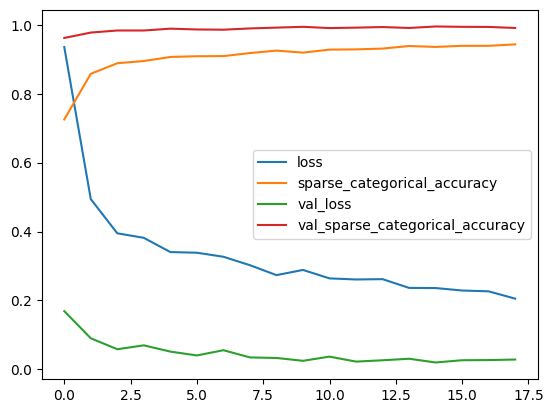

In [37]:
loss_df.plot();

In [38]:
model.evaluate(test_data)

94/94 [==============================] - 7s 76ms/step - loss: 0.0330 - sparse_categorical_accuracy: 0.9930


[0.032989103347063065, 0.9929999709129333]

In [ ]:
# os.makedirs(os.path.join("drive", "MyDrive", "vegetable_classification_models"))

In [39]:
model.save(os.path.join("drive", "MyDrive", "vegetable_classification_models","vegetable_classification_model_mnet.h5"))

MODEL QUANTIZATION

In [40]:
model = tf.keras.models.load_model(os.path.join("drive", "MyDrive", "vegetable_classification_models","vegetable_classification_model_mnet.h5"))

In [41]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

In [ ]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(training_data).batch(1).take(100):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:789: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


SAVING TFLITE MODEL

In [42]:
import pathlib

tflite_models_dir = pathlib.Path(os.path.join("drive", "MyDrive", "vegetable_classification_models"))
tflite_models_dir.mkdir(exist_ok=True, parents=True)
tflite_model_file = tflite_models_dir/"vegetable_classification_model_mnet.tflite"
tflite_model_file.write_bytes(tflite_model)

24936228

TFLITE MODEL INFERENCE

In [ ]:
import tensorflow.lite as lite
import os
from matplotlib.pyplot import imread
from numpy import expand_dims

In [ ]:
# def predict(tflite_file, test_image):
#   interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
#   interpreter.allocate_tensors()

#   input_details = interpreter.get_input_details()[0]
#   output_details = interpreter.get_output_details()[0]

#   test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
#   interpreter.set_tensor(input_details["index"], test_image)
#   interpreter.invoke()
#   output = interpreter.get_tensor(output_details["index"])[0]

#   predictions = output.argmax()
#   # predictions = output

#   return predictions

In [ ]:
def predict(tflite_file, test_image):
  interpreter = lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  test_image = expand_dims(test_image, axis=0).astype(input_details["dtype"])
  interpreter.set_tensor(input_details["index"], test_image)
  interpreter.invoke()
  output = interpreter.get_tensor(output_details["index"])[0]

  predictions = output.argmax()
  # predictions = output

  return predictions

In [ ]:
CLASS_INDICES = {'Bean': 0,
 'Bitter_Gourd': 1,
 'Bottle_Gourd': 2,
 'Brinjal': 3,
 'Broccoli': 4,
 'Cabbage': 5,
 'Capsicum': 6,
 'Carrot': 7,
 'Cauliflower': 8,
 'Cucumber': 9,
 'Papaya': 10,
 'Potato': 11,
 'Pumpkin': 12,
 'Radish': 13,
 'Tomato': 14}
DATA_PATH = os.path.join('Vegetable Images')
TEST_PATH = os.path.join(DATA_PATH, "test")

In [ ]:
test_image = imread(os.path.join(TEST_PATH, "Carrot", "1033.jpg"))/255.
tflite_model_file = os.path.join("drive", "MyDrive", "vegetable_classification_models", "vegetable_classification_model.tflite")
[*CLASS_INDICES.keys()][predict(tflite_model_file, test_image)]

'Carrot'